In [1]:
import bnpm
import numpy as np
import matplotlib.pyplot as plt
import torch

In [2]:
# Set device for PyTorch
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

input_tensor.shape: torch.Size([10000, 10])
output_tensor.shape: torch.Size([10000, 1])


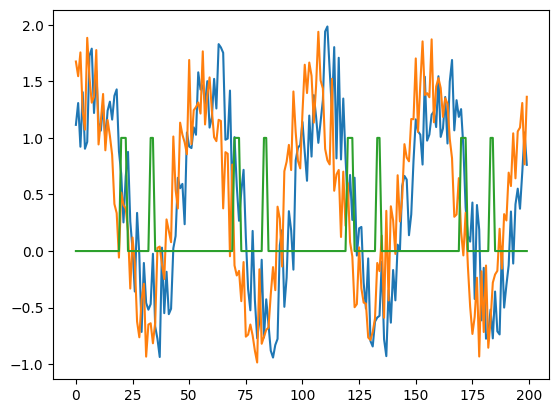

In [3]:
# Parameters for sine wave generation
num_periods = 200
num_samples = 10000
num_features = 10
noise_level = 1.0
phase_shift_input = 0.1 * np.pi
phase_shift_output = 1.4 * np.pi

# Generate sine wave data
time = np.linspace(0, num_periods * 2 * np.pi, num_samples)
input_wave = np.array([np.sin(time + phase_shift_input + ii * 2 * np.pi / num_features) for ii in range(num_features)])
input_wave += np.random.uniform(0, noise_level, input_wave.shape)  # Add noise
input_wave = input_wave.T  # Transpose to get shape (num_samples, num_features)

# Generate boolean output based on phase conditions
output_wave = np.sin(time + phase_shift_output)
output_wave = np.logical_and(output_wave >= np.sin(0.2 * np.pi), output_wave <= np.sin(0.3 * np.pi))
output_wave = output_wave.astype(np.float32).reshape(-1, 1)

# Convert to PyTorch tensors
input_tensor = torch.tensor(input_wave, dtype=torch.float32).to(DEVICE)
output_tensor = torch.tensor(output_wave, dtype=torch.float32).to(DEVICE)

print(f"input_tensor.shape: {input_tensor.shape}")
print(f"output_tensor.shape: {output_tensor.shape}")

plt.figure()
plt.plot(input_wave[:200,:2])
plt.plot(output_wave[:200])
plt.show()

In [ ]:
batch_duration = 500
dataset = torch.utils.data.TensorDataset(input_tensor, output_tensor)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_duration, shuffle=False)


# Model parameters
input_size = num_features
hidden_size = 50  # Can be tuned
num_layers = 2


model = bnpm.neural_networks.RegressionRNN(
    features=input_size, 
    hidden_size=hidden_size, 
    num_layers=num_layers, 
    output_size=1,
    batch_first=True,
    architecture='GRU',
    kwargs_architecture={},
    nonlinearity='tanh',
    bias=True,
    dropout=0.5,
    bidirectional=False,
    device='cpu',
    dtype=torch.float32,
).to(DEVICE)

# Loss and optimizer
criterion = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training loop (simplified for demonstration)
num_epochs = 50

model.train()
loss_all = {}
for epoch in range(num_epochs):
    for iter_x, (x_batch, y_batch) in enumerate(dataloader):
        x_batch = x_batch[None,...]
        y_batch = y_batch[None,...]
        
        hidden = model.initialize_hidden(x_batch.shape[0], hidden_initialization='zeros')
    
        optimizer.zero_grad()
        outputs, hidden = model.forward(
            x=x_batch,
            hidden=hidden,
            # hidden_initialization='zeros',
        ) 
        # Ensure output dimensions match target dimensions
        loss = criterion(outputs.view(-1, 1), y_batch.view(-1,1))
        loss.backward()
        optimizer.step()
    
        loss_all[(epoch, iter_x)] = loss.item()
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

    if epoch >= num_epochs:
        break


Epoch [1/50], Loss: 0.7047
Epoch [1/50], Loss: 0.6795
Epoch [1/50], Loss: 0.6589
Epoch [1/50], Loss: 0.6372
Epoch [1/50], Loss: 0.6134
Epoch [1/50], Loss: 0.5897
Epoch [1/50], Loss: 0.5654
Epoch [1/50], Loss: 0.5475
Epoch [1/50], Loss: 0.5191
Epoch [1/50], Loss: 0.4962
Epoch [1/50], Loss: 0.4748
Epoch [1/50], Loss: 0.4522
Epoch [1/50], Loss: 0.4339
Epoch [1/50], Loss: 0.4065
Epoch [1/50], Loss: 0.3862
Epoch [1/50], Loss: 0.3674
Epoch [1/50], Loss: 0.3520
Epoch [1/50], Loss: 0.3429
Epoch [1/50], Loss: 0.3323
Epoch [1/50], Loss: 0.3286
Epoch [2/50], Loss: 0.3232
Epoch [2/50], Loss: 0.3237
Epoch [2/50], Loss: 0.3204
Epoch [2/50], Loss: 0.3247
Epoch [2/50], Loss: 0.3260
Epoch [2/50], Loss: 0.3205
Epoch [2/50], Loss: 0.3240
Epoch [2/50], Loss: 0.3252
Epoch [2/50], Loss: 0.3214
Epoch [2/50], Loss: 0.3183
Epoch [2/50], Loss: 0.3180
Epoch [2/50], Loss: 0.3111
Epoch [2/50], Loss: 0.3089
Epoch [2/50], Loss: 0.3013
Epoch [2/50], Loss: 0.3033
Epoch [2/50], Loss: 0.3003
Epoch [2/50], Loss: 0.2975
E

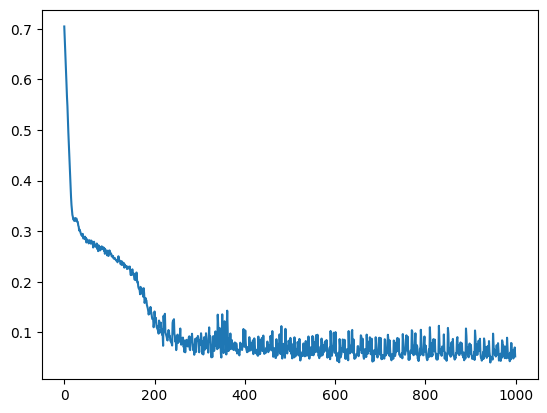

In [20]:
plt.figure()
plt.plot(list(loss_all.values()))

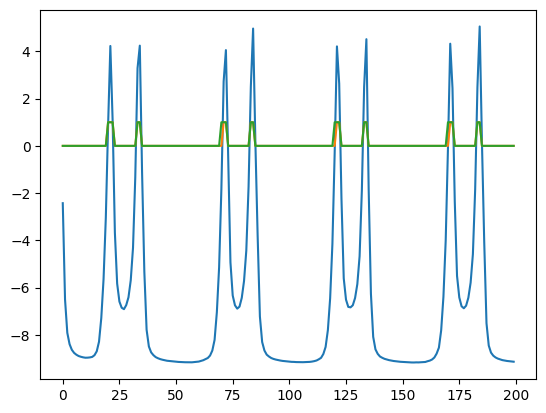

In [21]:
## Test the model
model.eval()
with torch.no_grad():
    hidden = model.initialize_hidden(1, hidden_initialization='zeros')
    output, hidden = model.forward(x=input_tensor[None,...], hidden=hidden)
    output = output.cpu().numpy().flatten()

plt.figure()
plt.plot(output[:200])
plt.plot((output > 0.5)[:200])
plt.plot(output_wave[:200])